In [1]:
from bs4 import BeautifulSoup 
import string, unicodedata , contractions , json , re
from nltk.corpus import stopwords 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,GlobalAveragePooling1D,Bidirectional,LSTM
import numpy as np ; import matplotlib.pyplot as plt

In [2]:
STOPWORDS = stopwords.words("english")

In [3]:
data  = []
with open("C:/codes/machineL/data/scarcasm/Sarcasm_Headlines_Dataset_v2.json","r") as f:
    for line in f:
        data.append(json.loads(line))

In [4]:
def remove_html_tags(text):
    return BeautifulSoup(text,"html.parser").get_text()

def convert_unicode_data(text):
    return unicodedata.normalize("NFKD",text).encode("ascii","ignore").decode("utf-8","ignore")

def remove_urls(text):
    text =   re.sub('https?:\S*', ' ', text)
    text = re.sub('www?.\S*', ' ', text)
    return text 

def expand_contractions(text):
    expanded_words  = []

    for word in text :
        expanded_words.append(contractions.fix(word))
    return "".join(expanded_words)

def remove_mentions(text):
    text = re.sub(r'@\S*', ' ', text)
    text = re.sub(r'#\S*', ' ', text)
    return text

def removing_special_chars(text):
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
    return re.sub(pat,' ',text)

def removing_numbers(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern,' ',text)

def remove_punctuation(text):
    return ''.join([c for c in text if c not in string.punctuation])



def clean_text(text):
    text = text.lower()
    text = remove_html_tags(text)
    text = convert_unicode_data(text)
    text = remove_urls(text)
    text = expand_contractions(text)
    text = remove_mentions(text)
    text = removing_numbers(text)
    text = remove_punctuation(text)
    text = " ".join(w for w in text.split() if w not in STOPWORDS)
    return text 

In [5]:
headlines = []
labels = []
for item in data :
    headlines.append(clean_text(item["headline"]))
    labels.append(item["is_sarcastic"])

In [6]:
train_size= 23000
last_size=  28000
training_data = headlines[0:train_size]
testing_data = headlines[train_size:last_size]
training_labels= np.array(labels[0:train_size])
testing_labels = np.array(labels[train_size:last_size])

In [7]:
num_words  = 20000 # vocab size also 
oov_token = "<OOV>"
pad_type = "post"
trunc_type="post"
embed_dim = 16


In [8]:
token = Tokenizer(num_words=num_words,oov_token=oov_token)
token.fit_on_texts(training_data)

In [9]:
train_data = token.texts_to_sequences(training_data)
train_data = pad_sequences(train_data,padding=pad_type,truncating=trunc_type)
train_data = np.array(train_data)

In [10]:
test_data = token.texts_to_sequences(testing_data)
test_data = pad_sequences(test_data,padding=pad_type,truncating=trunc_type)
test_data = np.array(test_data )

In [11]:
model = Sequential([
    Embedding(num_words,embed_dim),
    Bidirectional(LSTM(embed_dim,return_sequences=True)),
    Bidirectional(LSTM(embed_dim)),
    Dense(24,activation="relu"),
    Dense(1,activation="sigmoid")
])

In [12]:
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["acc"])

In [13]:
history = model.fit(train_data,training_labels,validation_data=(test_data,testing_labels),epochs=10)

Epoch 1/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 77s 90ms/step - acc: 0.6513 - loss: 0.5808 - val_acc: 0.8034 - val_loss: 0.4249
Epoch 2/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 80s 88ms/step - acc: 0.8947 - loss: 0.2637 - val_acc: 0.8074 - val_loss: 0.4432
Epoch 3/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 65s 91ms/step - acc: 0.9400 - loss: 0.1597 - val_acc: 0.7934 - val_loss: 0.4695
Epoch 4/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 88s 99ms/step - acc: 0.9456 - loss: 0.1465 - val_acc: 0.7832 - val_loss: 0.5745
Epoch 5/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 75s 90ms/step - acc: 0.9616 - loss: 0.1073 - val_acc: 0.7854 - val_loss: 0.6548
Epoch 6/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 65s 91ms/step - acc: 0.9738 - loss: 0.0855 - val_acc: 0.7856 - val_loss: 0.6739
Epoch 7/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 84s 93ms/step - acc: 0.9816 - loss: 0.0652 - val_acc: 0.7850 - val_loss: 0.7377
Epoch 8/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 83s 95ms/step - acc: 0.9833 - loss: 0.0578 - val_acc: 0.7846 - val_loss: 0.7550
Epoch 9/10
719/719 ━━━━━━━━━━━━━━━━━━━━ 

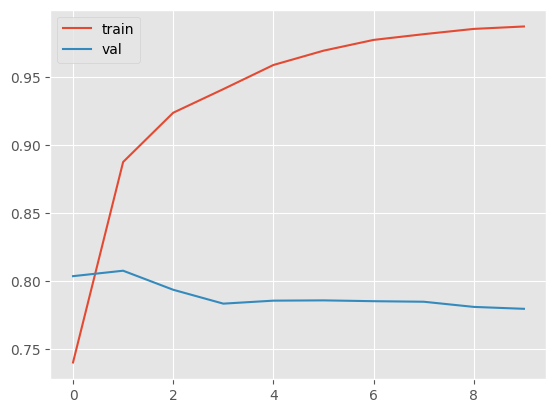

In [14]:
## Accuracy
plt.style.use("ggplot")
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(["train","val"],loc='upper left')

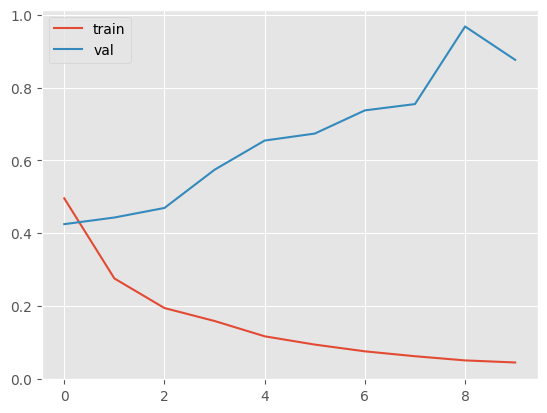

In [16]:
## Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["train", "val"],loc='upper left')